In [1]:
%run tools.ipynb

### play with NN model

In [2]:
# --- import necessary libraries

from xenonpy.model import Layer1d
from torch.nn import Sequential
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import plotly.express as px

In [3]:
from xenonpy.model.training import Trainer, SGD, MSELoss
from xenonpy.model.utils import regression_metrics
from xenonpy.model.training.extension import TensorConverter, Validator

In [4]:
x = np.linspace(-1, 1, 100)
y = np.power(x, 2) + 0.2 * np.random.rand(x.size)

x_val = np.linspace(-1, 1, 100)
y_val = np.power(x_val, 2) + 0.2 * np.random.rand(x_val.size)

In [5]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

In [6]:
torch.manual_seed(1)

trainer = Trainer(
    model=Net(n_feature=1, n_hidden=10, n_output=1),
    optimizer=SGD(),
    loss_func=MSELoss(),
    epochs=100
)

trainer.extend(
    TensorConverter(),
    Validator(
        x_val=x_val,
        y_val=y_val,
        metrics_func=regression_metrics),
)
trainer

Trainer(cuda=None, epochs=100, loss_func=MSELoss(), lr_scheduler=None,
        model=Net(
  (hidden): Linear(in_features=1, out_features=10, bias=True)
  (predict): Linear(in_features=10, out_features=1, bias=True)
),
        model_modifier=None,
        optimizer=SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
),
        verbose=True)

In [50]:
trainer.fit(x, y, epochs=10, save_training_state=True)

Training: 100%|██████████| 10/10 [00:00<00:00, 295.34it/s]


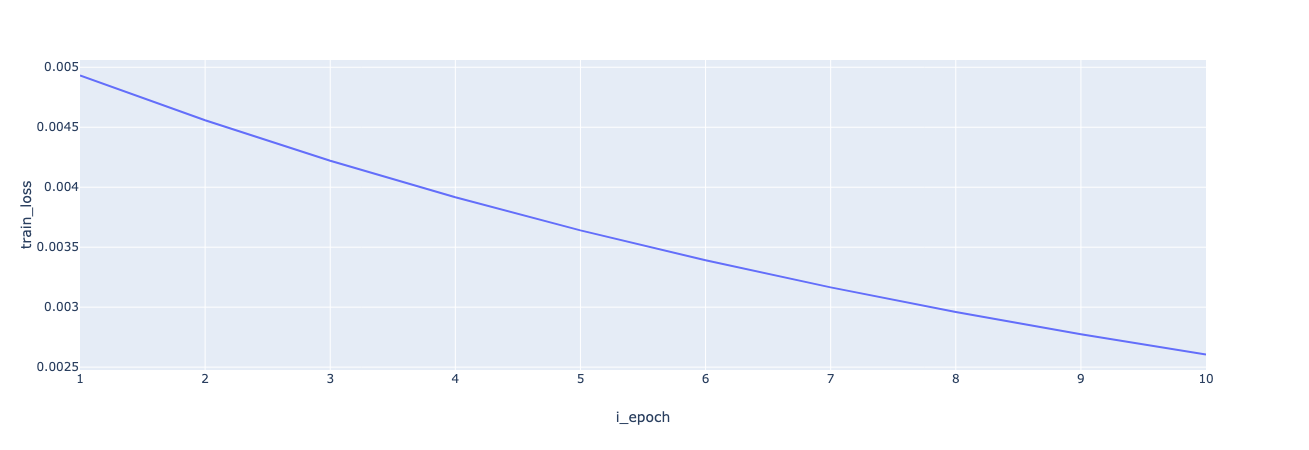

In [51]:
fig = px.line(trainer.step_info, x='i_epoch', y='train_loss')
fig.show()


In [49]:
trainer.reset()

# Model training

In [7]:
from xenonpy.model.training import Trainer, SGD, MSELoss, Adam, ReduceLROnPlateau, ExponentialLR
from xenonpy.model.training.extension import Validator, TensorConverter
from xenonpy.model.training.dataset import ArrayDataset
from xenonpy.datatools import preset, Splitter
from xenonpy.descriptor import Compositions

In [8]:
# --- build nn regression model

def Net(n_feature, n_hidden1, n_hidden2, n_hidden3, n_output):
    return Sequential(
        Layer1d(n_in=n_feature, n_out=n_hidden1), 
        Layer1d(n_in=n_hidden1, n_out=n_hidden2),
        Layer1d(n_in=n_hidden2, n_out=n_hidden3),
        Layer1d(n_in=n_hidden3, n_out=n_output, act_func=None, batch_nor=None)
    ) 

In [9]:
data = preset.mp_inorganic
data = data.sample(3000)
data.head(5)

,band_gap,composition,density,e_above_hull,efermi,elements,final_energy_per_atom,formation_energy_per_atom,has_bandstructure,is_hubbard,is_ordered,n_elemets,nsites,oxide_type,point_group,pretty_formula,space_group,space_group_number,total_magnetization,volume
mp-1106099,0.8314,"{'Y': 4.0, 'Mn': 2.0, 'Cr': 2.0, 'O': 12.0}",5.478822,0.031870,NaN,"[Cr, Mn, O, Y]",-8.436762,-3.093132,False,True,True,4,20,oxide,2/m,Y2MnCrO6,P2_1/c,14,7.000000e+00,230.793189
mp-1036521,0.0682,"{'Mg': 14.0, 'Nb': 1.0, 'Al': 1.0, 'O': 16.0}",3.755462,0.192403,NaN,"[Al, Mg, Nb, O]",-6.088761,-2.837082,False,False,True,4,32,oxide,4/mmm,Mg14NbAlO16,P4/mmm,123,1.168923e+00,316.656739
mp-1222592,0.7492,"{'Li': 1.0, 'In': 1.0, 'Mo': 6.0, 'Se': 6.0}",5.561603,0.069122,NaN,"[In, Li, Mo, Se]",-6.951069,-0.467434,False,False,True,4,14,None,-6,LiIn(MoSe)6,P-6,174,0.000000e+00,349.675294
mp-4993,0.0000,"{'Tb': 2.0, 'Si': 4.0, 'Ni': 2.0}",6.923113,0.000000,7.242223,"[Ni, Si, Tb]",-6.162376,-0.847000,True,False,True,3,8,None,mmm,TbSi2Ni,Cmcm,63,4.000000e-07,131.339349
mp-27537,1.8037,"{'O': 16.0, 'Na': 8.0, 'Te': 4.0}",4.127559,0.002502,2.140136,"[Na, O, Te]",-5.071717,-1.828781,True,False,True,3,28,oxide,mmm,Na2TeO4,Pbcn,60,6.542750e-04,382.314211


In [ ]:
desc = Compositions(featurizers='classic').transform(data['composition']).astype('float32')
prop = data['volume'].to_frame().astype('float32')

desc.head(5)
prop.head(5)

In [ ]:
sp = Splitter(3000)
x_train, x_test, y_train, y_test = sp.split(desc, prop)

In [ ]:
x_train.shape
y_train.shape
x_test.shape
y_test.shape

In [101]:
# --- check model
nn_model = Net(
    n_feature=290,
    n_hidden1=200,
    n_hidden2=100,
    n_hidden3=30,
    n_output=1)

nn_model

Sequential(
  (0): Layer1d(
    (layer): Linear(in_features=290, out_features=200, bias=True)
    (batch_nor): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
  )
  (1): Layer1d(
    (layer): Linear(in_features=200, out_features=100, bias=True)
    (batch_nor): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
  )
  (2): Layer1d(
    (layer): Linear(in_features=100, out_features=30, bias=True)
    (batch_nor): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
  )
  (3): Layer1d(
    (layer): Linear(in_features=30, out_features=1, bias=True)
  )
)

In [29]:
trainer = Trainer(
    model=nn_model,
#     optimizer=SGD(lr=0.001, momentum=0.8, dampening=0.7, weight_decay=0.1),
    optimizer=Adam(lr=0.01, weight_decay=0.1),
    loss_func=MSELoss(),
#     lr_scheduler=ReduceLROnPlateau(),
    epochs=1000,
)

In [30]:
trainer.extend(
    TensorConverter(),
    Validator(x_test, y_test,
        metrics_func=regression_metrics),
)

In [31]:
from torch.utils.data import DataLoader, TensorDataset

In [32]:
dataloader = DataLoader(
    TensorDataset(
        torch.from_numpy(x_train),
        torch.from_numpy(y_train)),
    shuffle=True,
    batch_size=200
)

In [ ]:
trainer.fit(x_train=x_train, y_train=y_train, epochs=10)

Training:  30%|███       | 3/10 [00:00<00:00, 25.55it/s]

In [25]:
trainer.fit(training_dataset=dataloader, epochs=100)

Training: 100%|██████████| 100/100 [00:09<00:00, 10.87it/s]


In [26]:
trainer.timer

Total elapsed: 0:00:09.433292 <seconds>
  |- fit: 0:00:09.414722
  |- _step_forward: 0:00:00.007380
  |- input_proc: 0:00:00.006016
  |- output_proc: 0:00:00.005166
  |- _before_proc: 0:00:00.000005
  |- _after_proc: 0:00:00.000003

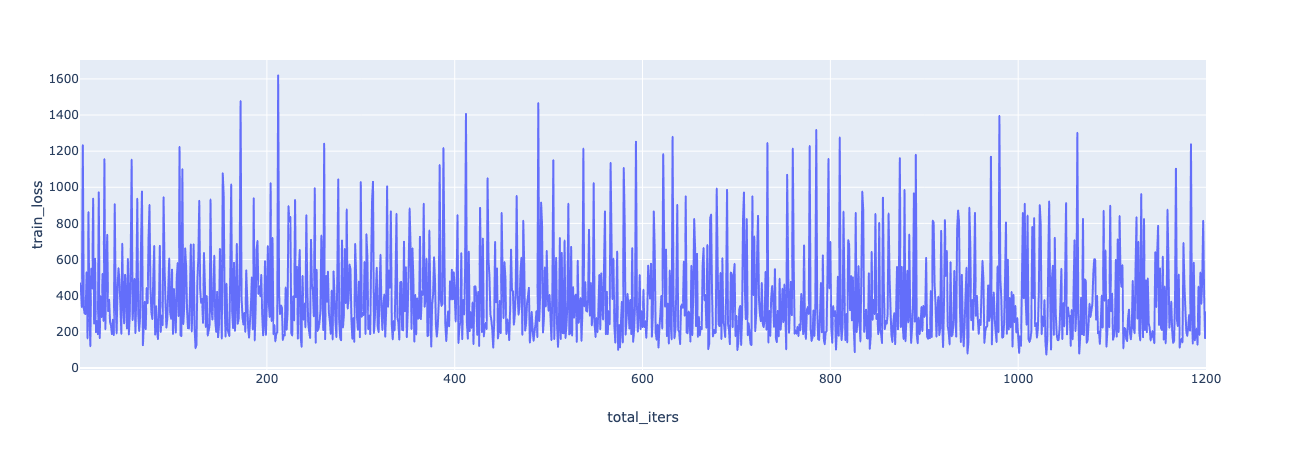

In [27]:
fig = px.line(trainer.step_info, x='total_iters', y='train_loss')
fig.show()


# Model testing

In [21]:
y_pred = trainer.predict(x_test)

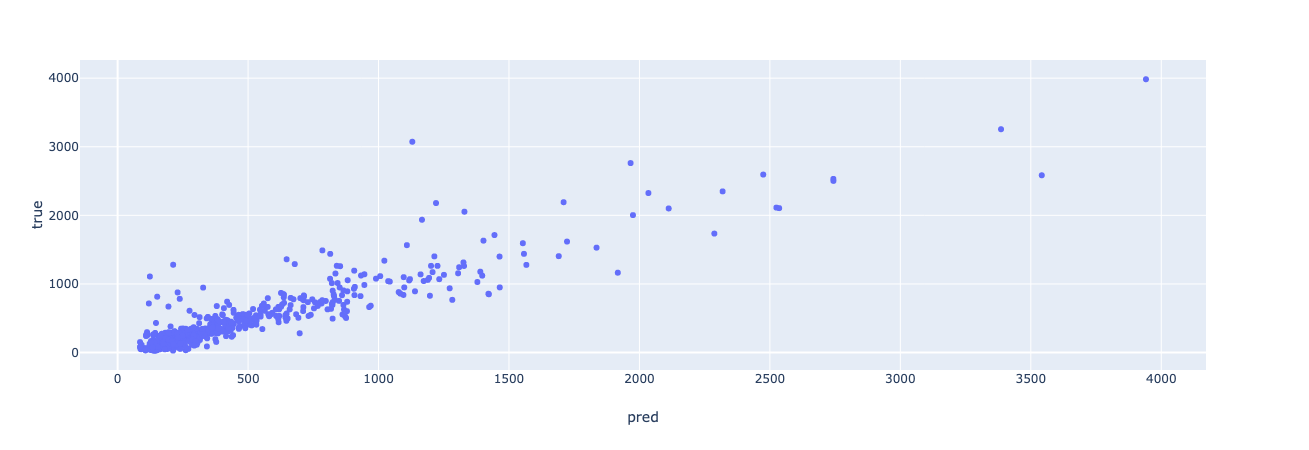

In [22]:
fig = px.scatter(pd.DataFrame({'pred': y_pred.flatten(), 'true': y_test.flatten()}), x='pred', y='true')
fig.show()

### model building with random hyper parameters

In [25]:
# --- import necessary libraries

from xenonpy.model.nn import Generator1d
from xenonpy.model.nn import wrap

# 3rd packages
from torch.nn import ReLU, Tanh
from math import ceil

In [26]:
# parameter scheduler
def scheduler(i, paras):
    n_out = max(ceil(paras['n_out'] * uniform(0.3, 0.8)),5)
    return dict(paras, n_out=n_out)

# model generator
generator = Generator1d(290, 1,  # num of input an output neuron
                n_neuron=[ceil(uniform(0.8, 1.0) * 150) for n in range(5)],  # variety of neuron num in each layer
                act_func=(ReLU(),),   # variety of activation function in each layer
                drop_out=(0.1,),  # variety of dropout rate in each layer
                batch_normalize=(wrap.L1.batch_norm(),)
               )

In [30]:
# --- generate models

models = generator(4, n_models=1, replace=True, scheduler=scheduler)

In [31]:
# --- check the model generator

models

<generator object Generator1d.__call__ at 0x1a48e97ca8>

In [32]:
model = list(models)[0]
model

Sequential(
  (0): Layer1d(
    (layer): Linear(in_features=290, out_features=125, bias=True)
    (batch_nor): BatchNorm1d(125, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
    (dropout): Dropout(p=0.1)
  )
  (1): Layer1d(
    (layer): Linear(in_features=125, out_features=69, bias=True)
    (batch_nor): BatchNorm1d(69, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
    (dropout): Dropout(p=0.1)
  )
  (2): Layer1d(
    (layer): Linear(in_features=69, out_features=38, bias=True)
    (batch_nor): BatchNorm1d(38, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
    (dropout): Dropout(p=0.1)
  )
  (3): Layer1d(
    (layer): Linear(in_features=38, out_features=16, bias=True)
    (batch_nor): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_func): ReLU()
    (dropout): Dropout(p=0.1)
  )
  (4): Linear(in_features=16, out_features=1, bi